In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install botorch
# !pip install autograd-minimize

In [3]:
# !git clone https://github.com/rfeinman/pytorch-minimize.git
# %cd pytorch-minimize
# !pip install -e .

In [4]:
import math
import numpy as np

import torch.nn.functional as F
import torch.nn as nn
import torch

import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
#####################################################
### FUNCTIONS FOR PLOTTING/VISUALIZING TRAJECTORY ###
#####################################################

def rotate(x, y, angle):
    return [x * np.cos(np.radians(angle)) - y * np.sin(np.radians(angle)), 
            x * np.sin(np.radians(angle)) + y * np.cos(np.radians(angle))]


def plot_map(roadMap, centerLine, xlim=None, ylim=None):

    plt.figure(figsize=(15, 5))
    if xlim or ylim:
        plt.autoscale(False)
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
    
    label = True
    for road in roadMap[1:-1]:
        if label:
            plt.plot(*zip(*road), color='gold', linestyle='--', label='lane line')
            label = False
        else:
            plt.plot(*zip(*road), color='gold', linestyle='--')
    
    plt.plot(*zip(*roadMap[0]), color='black')
    plt.plot(*zip(*roadMap[-1]), color='black', label='boundary line')
    
    plt.plot(*zip(*centerLine), color='red', label='centerline')

    plt.plot(0, 0, 'bo', markersize=5, label='ego')
    plt.legend()

    plt.show()


def plot_trajectory(states, 
                    roadMap, 
                    centerLine, 
                    objects, 
                    savefig=None,
                    xlim=None, 
                    ylim=None, 
                    verbose=False):

    plt.figure(figsize=(15, 5))
    if xlim or ylim:
        plt.autoscale(False)
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)

    for i, road in enumerate(roadMap[1:-1]):
        if i == 0:
            plt.plot(*zip(*road), color='gold', linestyle='--', label='lane line')
        else:
            plt.plot(*zip(*road), color='gold', linestyle='--')
    
    plt.plot(*zip(*roadMap[0]), color='black', label='boundary line')
    plt.plot(*zip(*roadMap[-1]), color='black')
    
    plt.plot(*zip(*centerLine), color='red', label='centerline')

    label = True
    for obj in objects:
        x, y = obj
        if x != 0 or y != 0:
            if label:
                plt.plot(x, y, 'ro', markersize=5, label='obstacles')
                label = False
            else:
                plt.plot(x, y, 'ro', markersize=5)

    colors = cm.rainbow(np.linspace(0, 1, len(states)))
    for i, state in enumerate(states):
        x, y, velocity, heading = state
        heading = heading % 360 
        if verbose:
            print(f"x: {x}, y: {y}, velocity: {velocity}, heading: {heading}")
            print(f"centerline error: {shortestDistanceToPolylineNumpy(np.array([x, y]), centerLine)}")
        # plot triangles
        plt.plot(x, y, marker=(3, 0, heading - 90), markersize=7, color=colors[i])
    print('\n' * 2)

    plt.legend()

    if savefig:
        plt.savefig(savefig)

    plt.show()

In [6]:
############################################################
### NUMPY OPERATIONS FOR EVALUATING AND PLOTTING OUTPUTS ###
############################################################

def shortestDistanceToPolylineNumpy(pt, centerLinePts):

    distance = float('inf')

    for i in range(1, len(centerLinePts)):
        ptA, ptB = centerLinePts[i - 1], centerLinePts[i]
        # see here: http://www.math.lsa.umich.edu/~glarose/classes/calcIII/web/13_5/
        # shift points to origin (offset by ptA)
        ptShift = pt - ptA
        centerLine = ptB - ptA

        projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / np.linalg.norm(centerLine, ord=2)
        projection = projection * centerLine + ptA

        rejection_dist = np.sqrt(np.square(pt[0] - projection[0]) + np.square(pt[1] - projection[1]))
        distance = np.minimum(rejection_dist, distance)

    return distance


def stateUpdateEqnNumpy(state, controls, timeStep):
    controls[0, 0] = state[2, 0] * np.cos(np.deg2rad(state[3, 0]))
    controls[1, 0] = state[2, 0] * np.sin(np.deg2rad(state[3, 0]))
    return state + timeStep * controls


def getUpdatedStates(initialState, controls, timeStep=1):
    state = initialState[0][:-1]
    states = [state]
    for control in controls[0]:
        paddedControls = np.concatenate((np.zeros((2, 1)), control))
        state = stateUpdateEqnNumpy(state, constraints @ paddedControls, timeStep)
        states.append(state)
    return states

Input a number of things:

1. k nearest objects to us, with predictions of locations in near future
2. Road-map, center-lines, etc. (polylines as features)
3. Desired waypoint destination (x, y features) given by another larger coarse network

In [7]:
##########################
### MODEL ARCHITECTURE ###
##########################

# Concatenater of all embedding networks
class PathPlanner(nn.Module):
    def __init__(self, 
                 output_size,
                 hidden_size, 
                 n_features,
                 y_features, 
                 k_neighbors,
                 num_layers, 
                 road_samples,
                 gpu=0):
        super(PathPlanner, self).__init__()

        self.gpu = gpu

        road_samples, road_embedding = road_samples
        # path planner feature dimension
        input_size = n_features + road_samples // road_embedding * 3 + k_neighbors 

        self.env_embed = EnvironmentMapper()
        self.road_embed = RoadMapper(road_samples, road_embedding)
        self.planner = MotionPlanner(input_size, hidden_size, output_size, num_layers, y_features)


    def forward(self, x, roadmap, environment):
        env_embedded = self.env_embed(environment)
        map_embedded = self.road_embed(roadmap)
        
        x = torch.cat((x, map_embedded, env_embedded), axis=-1)
        y = self.planner(x)

        return y


# Motion planning network (RNN)
class MotionPlanner(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 num_steps,
                 num_layers,
                 y_features):
        super(MotionPlanner, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = num_steps

        self.features_embed = nn.Linear(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, 
                          hidden_size, 
                          num_layers, 
                          batch_first=True)
        self.fc1 = nn.Linear(hidden_size, y_features)


    def forward(self, x):
        batch_size = x.size(0)
        x = self.features_embed(x)
        x = nn.Tanh()(x)

        # Set initial hidden and cell states
        # h_n = torch.randn(self.num_layers, batch_size, self.hidden_size, dtype=torch.double)
        # h_n = torch.zeros(self.num_layers, batch_size, self.hidden_size, dtype=torch.double)
        h_n = torch.ones(self.num_layers, batch_size, self.hidden_size, dtype=torch.double)

        y = torch.zeros(batch_size, self.output_size, self.hidden_size, dtype=torch.double)
        for i in range(self.output_size):
            output_n, h_n = self.rnn(x, h_n)
            # x, h_n = self.rnn(x, h_n)
            y[:,i,:] = output_n
        
        y = self.fc1(y)
        y = nn.Tanh()(y)
        y = torch.unsqueeze(y, axis=-1)

        return y


# Road embedder (FCNN)
class RoadMapper(nn.Module):
    def __init__(self, samples, embedding):
        super(RoadMapper, self).__init__()
        self.fc1 = nn.Linear(2, 1)
        self.fc2 = nn.Linear(samples, samples // embedding)
    
    def forward(self, x):
        x = self.fc1(x)
        x = nn.Tanh()(x)
        x = torch.squeeze(x, axis=-1)

        x = self.fc2(x)
        x = nn.Tanh()(x)

        x = torch.flatten(x, start_dim=1)
        x = torch.unsqueeze(x, dim=1)

        return x


# Obstacle embedder (FCNN)
class EnvironmentMapper(nn.Module):
    def __init__(self):
        super(EnvironmentMapper, self).__init__()
        self.fc1 = nn.Linear(2, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = torch.swapaxes(x, -1, -2)

        return x

In [8]:
# Use straight line and put vehicles in the center of the line

# TODO: Put unused object positions at the origin and do not account for them in the loss function !!!!!

# validate avoidance
def validate_avoidance(traj, objects):
    min_dist = float('inf')
    for pt in traj[1:]:
        x, y, _, _ = pt
        for obj in objects:
            obj_x, obj_y = obj
            dist = math.sqrt((x - obj_x) ** 2 + (y - obj_y) ** 2)
            min_dist = min(dist, min_dist)
    return min_dist

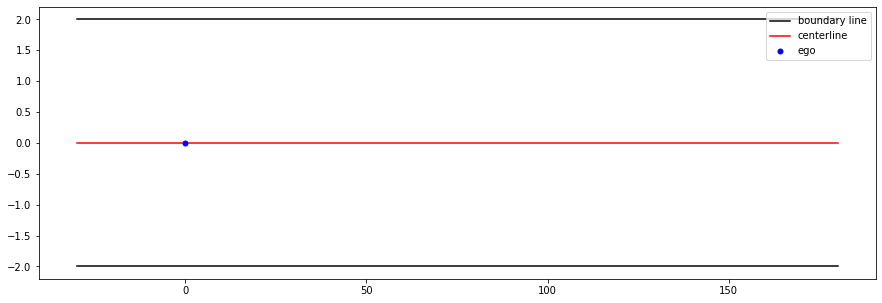

In [22]:
##################################
### DATASET BUILDING FUNCTIONS ###
##################################

from torch.utils.data import Dataset

class ControlsDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        return self.data[0][idx], self.data[1][idx]


def buildDataset(n, desired_v, init_velocity=None, init_heading=None, n_objects=100):
    positionalData = []
    environmentalData = []

    for _ in range(n):
        v, h = 0, 0
        if init_velocity is not None:
            v = init_velocity
        if init_heading is not None:
            h = init_heading

        positionalData.append([[v, h, desired_v]])

        object_positions = []
        # k = np.random.randint(1, n_objects + 1)
        k = 30
        x, y = 60, -7
        for _ in range(k):
            object_positions.append([x, y])
            y += .5
        
        for _ in range(n_objects - k):
            object_positions.append([0, 0])

        environmentalData.append(object_positions)
    
    return np.array(positionalData), np.array(environmentalData)


#########################################
### CREATE ROAD LINES POLYLINE POINTS ###
#########################################


slope_fn = lambda pt1, pt2: [pt2[0] - pt1[0], pt2[1] - pt1[1]]

def create_parallel_polyline(polyline, slopes, width, lane_no):
    shift = lane_no * width
    parallel_polyline = [np.array([polyline[0,0], polyline[0,1] - shift])]
    for slope in slopes:
        parallel_polyline.append(parallel_polyline[-1] + slope)
    return parallel_polyline


def create_generalized_scenario(func, 
                                domain, 
                                lane_width, 
                                n_lanes, 
                                centerline_no,
                                n_samples=200):
    
    domain = np.linspace(domain[0], domain[1], n_samples)
    left = np.array([[x, func(x)] for x in domain])
    slopes = np.array([slope_fn(left[i-1], left[i]) for i in range(1, len(left))])
    road_map = [left]
    for n in range(n_lanes):
        road_map.append(create_parallel_polyline(left, slopes, lane_width, n+1))
    centerline = create_parallel_polyline(left, slopes, lane_width, centerline_no+0.5)
    road_map = np.array(road_map)

    return road_map, centerline


def shift_coordinate_frame(roadMap, centerlane, egoPos):
    egoPos = np.array([egoPos[0], egoPos[1]])
    shiftedRoadMap = []
    for lane in roadMap:
        shiftedRoadMap.append(lane - egoPos)
    shiftedRoadMap = np.array(shiftedRoadMap)    
    centerlane = centerlane - egoPos
    return shiftedRoadMap, centerlane


road3_formula = lambda x: math.exp(x / 20) + 1
road3, road3_cl = create_generalized_scenario(road3_formula,
                                              domain=(-10, 50),
                                              lane_width=4, 
                                              n_lanes=1,
                                              centerline_no=0,
                                              n_samples=500)
road3, road3_cl = shift_coordinate_frame(road3, road3_cl, (0, 0.5))


road1_formula = lambda x: 1/10 * x + 0
road1, road1_cl = create_generalized_scenario(road1_formula, 
                                              domain=(-30, 100), 
                                              lane_width=4, 
                                              n_lanes=2,
                                              centerline_no=1,
                                              n_samples=500)
road1, road1_cl = shift_coordinate_frame(road1, road1_cl, (0, -2.5))


road2_formula = lambda x: 10 * math.log(x + 10) - 30
road2, road2_cl = create_generalized_scenario(road2_formula, 
                                              domain=(-5, 150),
                                              lane_width=4,
                                              n_lanes=3,
                                              centerline_no=2,
                                              n_samples=500)
road2, road2_cl = shift_coordinate_frame(road2, road2_cl, (-3, -13))


road4_formula = lambda x: 0
road4, road4_cl = create_generalized_scenario(road4_formula, 
                                              domain=(-30, 150),
                                              lane_width=4,
                                              n_lanes=3,
                                              centerline_no=0,
                                              n_samples=500)
# road4, road4_cl = shift_coordinate_frame(road4, road4_cl, (0, -6))
road4, road4_cl = shift_coordinate_frame(road4, road4_cl, (0, -10))


road5_formula = lambda x: 0
road5, road5_cl = create_generalized_scenario(road5_formula, 
                                              domain=(-30, 180),
                                              lane_width=4,
                                              n_lanes=1,
                                              centerline_no=0,
                                              n_samples=500)
road5, road5_cl = shift_coordinate_frame(road5, road5_cl, (0, -2))



road6_formula = lambda x: -math.log(x + 1)
road6, road6_cl = create_generalized_scenario(road6_formula,
                                              domain=(0, 160),
                                              lane_width=4, 
                                              n_lanes=2,
                                              centerline_no=1,
                                              n_samples=500)
road6, road6_cl = shift_coordinate_frame(road6, road6_cl, (2, -4.4))

plot_map(road5, road5_cl)

In [23]:
#################################
### LOSS FUNCTION COMPUTATION ###
#################################


# state: [[x1, y1, v1, h1], [x2, y2, v2, h2], ...]
# controls: [vx, vy, a, w]
def stateUpdateEqn(state, controls, timeStep):
    controls[0, 0] = state[2, 0] * torch.cos(torch.deg2rad(state[3, 0]))
    controls[1, 0] = state[2, 0] * torch.sin(torch.deg2rad(state[3, 0]))
    return state + timeStep * controls


def shortestDistanceToPolyline(pt, centerLinePts, discretization=3):

    distance = torch.tensor(float('inf'))
    tangentLine = None 
    # iterate over polyline points
    for i in range(discretization, len(centerLinePts), discretization):
        ptA, ptB = centerLinePts[i - discretization], centerLinePts[i]
        centerLine = ptB - ptA

        # # find midpoint between two sequential points
        midPt = (ptA + ptB) / 2
        projection = midPt
        
        # computer rejection distance (project position onto line and take distance)
        # projection = (centerLine[0] * ptShift[0] + centerLine[1] * ptShift[1]) / torch.norm(centerLine, p=2)
        # projection = projection * centerLine + ptA

        # compute distance between position and mid-point, take the minimum across all
        rejection_dist = torch.sqrt(torch.square(pt[0] - projection[0]) + torch.square(pt[1] - projection[1]))
        if rejection_dist < distance:
            tangentLine = centerLine
            distance = rejection_dist

    return distance, torch.atan2(tangentLine[1], tangentLine[0])


# heading error computation
def computeHeadingError(realHeading, desiredHeading):
    delta = desiredHeading - torch.deg2rad(realHeading)
    return torch.rad2deg(torch.atan2(torch.sin(delta), torch.cos(delta)))


# constraints matrix scale values at the ouput of tanh [-1, 1]
constraints = np.array([[0, 0, 0, 0],
                        [0, 0, 0, 0],
                        [0, 0, 5, 0],
                        [0, 0, 0, 30]])


class PathLoss(nn.Module):

    def __init__(self, skip_polyline_pts):
        super(PathLoss, self).__init__()
        self.lineDiscretization = skip_polyline_pts


    def forward(self, position, direction, desiredVelocity, roadMap, verbose=False):
        # unwrap road map information
        leftBoundary, centerLine, rightBoundary = roadMap

        # boundaryErrorLeft, boundaryErrorRight = 0, 0
        # headingError = 0

        # compute distance from road boundaries (want to maximize this)
        boundaryErrorLeft, _ = shortestDistanceToPolyline(position, leftBoundary, self.lineDiscretization)
        boundaryErrorRight, _ = shortestDistanceToPolyline(position, rightBoundary, self.lineDiscretization)

        # compute distance from centerline (want to minimize this)
        lateralError, roadHeading = shortestDistanceToPolyline(position, centerLine, self.lineDiscretization)

        velocity, heading = direction
        # compute heading & velocity errors
        headingError = computeHeadingError(heading, roadHeading)
        velocityError = desiredVelocity - velocity

        # # turn max into min for distance from boundary lines
        boundaryErrorLeft = torch.exp(5 * (1 - .2 * boundaryErrorLeft))
        boundaryErrorRight = torch.exp(5 * (1 - .2 * boundaryErrorRight))

        return boundaryErrorLeft, boundaryErrorRight, lateralError, velocityError, headingError
        

# compute obstacle avoidance loss
class AvoidanceLoss(nn.Module):

    def __init__(self):
        super(AvoidanceLoss, self).__init__()

    def forward(self, position, objects):

        x, y = position

        avoidance_loss = 0
        for obj in objects:
            obj_x, obj_y = obj
            # ignore object if it is placeholder value
            if obj_x != 0.0 or obj_y != 0.0:
                distance = torch.sqrt(torch.square(x - obj_x) + torch.square(y - obj_y)) 
                avoidance_loss += torch.exp(2 * (4 - 0.5 * distance))
                # avoidance_loss += torch.exp(2 - distance)

        return avoidance_loss


class PlannerLoss(nn.Module):

    constraints = torch.tensor(constraints, dtype=torch.double)
    
    def __init__(self,
                 costWeights,
                 timeStep=1,
                 lineDiscretization=3,
                 gpu=False):
        super(PlannerLoss, self).__init__()

        self.avoid_loss_fn = AvoidanceLoss()
        self.path_loss_fn = PathLoss(lineDiscretization)

        self.gpu = gpu
        if gpu:
            self.constraints = self.constraints.cuda()
        
        self.timeStep = timeStep

        self.laneWeight = costWeights[4]
        self.avoidWeight = costWeights[3]
        self.headingWeight = costWeights[2]
        self.velocityWeight = costWeights[1]
        self.centerLineWeight = costWeights[0]


    def forward(self, initialState, controls, roadMaps, environments, verbose=False):
        totalBatchCost = 0
        batchDim = initialState.size(0)
        
        for i in range(batchDim):
            cost = 0
            # unwrap state, reduce last value in since it is desired velocity
            state = initialState[i,:-1,...]
            # unwrap desired velocity
            desiredVelocity = initialState[i,-1,0]
            # grab roadMap polyline points
            roadMap = roadMaps[i,...]
            # grab objects information
            objects = environments[i,...]
            for j in range(controls.size(1)):
                cost_j = 0

                if verbose:
                    x, y, velocity, heading = state
                    print(f"state {j+1}:")
                    # print(f"desired velocity: {desiredVelocity}")
                    print(f"x: {x[0]}, y: {y[0]}, velocity: {velocity[0]}, heading: {heading[0] % 360}")

                # pad controls to do easy matrix multiplication update newState = T * currState
                # where T is the transition matrix 
                paddedControls = torch.cat((torch.zeros(2, 1), controls[i,j,...]))
                state = stateUpdateEqn(state, torch.matmul(self.constraints, paddedControls), self.timeStep)

                # squeeze out last dimension so we can use list slicing on tensors
                stateSqueeze = torch.squeeze(state)
                positional_states, directional_states = stateSqueeze[:2], stateSqueeze[2:]                    

                # compute error associated with obstacle avoidance
                avoidanceError = self.avoid_loss_fn(positional_states, objects)
                
                # compute all errors associated with path loss
                concatErrors = self.path_loss_fn(positional_states, 
                                                 directional_states, 
                                                 desiredVelocity, 
                                                 roadMap,
                                                 verbose=verbose)
                boundaryErrorLeft, boundaryErrorRight, lateralError, velocityError, headingError = concatErrors

                # scale the weights increasing by time
                timeScalar = 1 # (j + 1)
                centerLineWeight = self.centerLineWeight * timeScalar
                headingWeight = self.headingWeight * timeScalar
                velocityWeight = self.velocityWeight * timeScalar

                # add all errors to cost function
                cost_j += centerLineWeight * torch.square(lateralError)
                cost_j += velocityWeight * torch.square(velocityError)
                cost_j += headingWeight * torch.abs(headingError)
                cost_j += self.laneWeight * boundaryErrorLeft
                cost_j += self.laneWeight * boundaryErrorRight 
                cost_j += self.avoidWeight * avoidanceError

                cost += cost_j

                if verbose:
                    print("Left boundary cost:", self.laneWeight * boundaryErrorLeft)
                    print("Right boundary cost:", self.laneWeight * boundaryErrorRight)
                    print("Center lane cost:", centerLineWeight * torch.square(lateralError))
                    print("Velocity cost:", velocityWeight * torch.square(velocityError))
                    print("Heading cost:", headingWeight * torch.abs(headingError))
                    print("Obstacle cost:", self.avoidWeight * avoidanceError)
                    print(f"Cost for time step {j + 1}: {cost_j}")
                    
            if verbose:
                print("Total cost:", cost)

            totalBatchCost += cost

        # return average of cost function across batch
        return totalBatchCost / batchDim

TODO: Make hidden size of four to encode the state information

For loss function, fix scalars. We want it to converge as soon as possible while giving it some distance to converge

Maybe just put loss on last state??

In [ ]:
from torch.utils.data import DataLoader

n_steps = 15 # number of output controls

n_features = 3 # velocity, heading, terminal velocity
n_layers = n_steps # number of layers in RNN

output_features = 2 # acceleration, angular velocity
hidden_dim = 300 # hidden dimension size

road_downsample = 6 # embedding size of road is len(road) / road_downsample

# choose which road map
road_map = road5
road_map_cl = road5_cl

# get only left boundary, centerline, right boundary
# expand dims to concatenate
left_boundary = np.expand_dims(road_map[0], axis=0)
center_lane = np.expand_dims(road_map_cl, axis=0)
right_boundary = np.expand_dims(road_map[-1], axis=0)
road_map_input = np.concatenate((left_boundary, center_lane, right_boundary))
xlim, ylim = None, None

# unsqueeze to add batch dimension 
road_map_input = torch.unsqueeze(torch.tensor(road_map_input), dim=0).double()

timestep = 1
desired_velocity = 1e-10 # m/s
init_heading = 0
init_velocity = 6

n_neighbors = 30

cost_fn_weights = [20, 11, 9, 100, 40] # centerLineWeight, velocityWeight, headingWeight, avoidanceWeight, boundaryWeight
# cost_fn_weights = [15, 8, 5, 40, 15] # centerLineWeight, velocityWeight, headingWeight, avoidanceWeight, boundaryWeight

model = PathPlanner(n_steps, hidden_dim, n_features, output_features, n_neighbors, n_layers, (road_map.shape[1], road_downsample))
model = model.double()

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of trainable params in model: {pytorch_total_params}\n')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = PlannerLoss(cost_fn_weights, timeStep=timestep, lineDiscretization=road_downsample)
x, environments = buildDataset(1, desired_velocity, init_velocity=init_velocity, init_heading=init_heading, n_objects=n_neighbors)

# pad the two zeros (x, y) to initial states
initial_states = np.concatenate((np.zeros((x.shape[0], 2, 1)), np.swapaxes(x, -1, -2)), axis=1)
x = torch.tensor(x, dtype=torch.double)
environments = torch.tensor(environments, dtype=torch.double)

print("inital heading", np.squeeze(initial_states)[-2] % 360, '\n')

initial_states = torch.tensor(initial_states, dtype=torch.double)

epochs = 500
display = 50

best_loss, best_soln = float('inf'), None

output_no = 0

for epoch in range(epochs + 1):
    model.train()

    output_info = epoch % display == 0 and epoch != 0

    controls_output = model(x, road_map_input, environments)
    loss = loss_fn(initial_states, 
                   controls_output,
                   road_map_input,
                   environments,
                   verbose=output_info)

    if loss < best_loss:
        best_loss = loss
        best_soln = getUpdatedStates(initial_states.detach().numpy(), controls_output.detach().numpy(), timestep)

    if output_info:
        savefig = f'/content/drive/My Drive/Research/Chance-Constraints/Traj-Outputs/{output_no}.png'
        print_states = getUpdatedStates(initial_states.detach().numpy(), controls_output.detach().numpy(), timestep)
        plot_trajectory(print_states, road_map, road_map_cl, environments.detach().numpy()[0], savefig=savefig, xlim=xlim, ylim=ylim, verbose=0)
        min_dist = validate_avoidance(print_states, environments.detach().numpy()[0])
        print(f'\nloss = {loss}')
        print(f'Minimum distance from objects: {min_dist}\n\n')
        output_no += 1

    model.zero_grad()

    loss.backward()
    optimizer.step()

Train full model below

In [ ]:
# from torch.utils.data import DataLoader

# batch_size = 10 
# n_workers = 1

# n_steps = 8

# train_dataset = ControlsDataset(buildDataset(100000, n_steps))
# val_dataset = ControlsDataset(buildDataset(20000, n_steps))
# # train_dataset = ControlsDataset(buildDataset(5, n_steps))
# # val_dataset = ControlsDataset(buildDataset(2, n_steps))
# validation_set = DataLoader(val_dataset,
#                             batch_size=batch_size,
#                             shuffle=True,
#                             num_workers=n_workers,
#                            )
# training_set = DataLoader(train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=n_workers,
#                          )
# dataset = { 'validation': validation_set, 'train': training_set }

In [ ]:
# n_features = 4
# n_layers = 7

# best_path = '/content/drive/My Drive/Research/cc_best.pth'
# chkpt_path = '/content/drive/My Drive/Research/cc_chkpt.pth'

# hidden_dim = n_features
# output_size = n_features

# learning_rate = 1e-2

# log_batch = 1000

# zero_heading = 270 # degrees(°)
# runway_heading = 54.331
# desired_states = (50, runway_heading + zero_heading) # m/s, degrees(°)
# center_line = torch.tensor([2421, -1737], dtype=torch.double)
# cost_fn_weights = [13, 2, 6] # centerLineWeight, velocityWeight, headingWeight

# gpu_exists = torch.cuda.device_count() > 0
# print(f'GPU: {int(gpu_exists)}')

# model = RNN(n_features, hidden_dim, output_size, n_layers, gpu=gpu_exists)
# model = model.double()
# model.load_state_dict(torch.load(chkpt_path))

# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f'Number of trainable params in model: {pytorch_total_params}')

# if gpu_exists:
#     model = model.cuda()
#     center_line = center_line.cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = PathLoss(desired_states, center_line, cost_fn_weights, gpu=gpu_exists)

# best_loss = 1e20
# epochs = 100
# for epoch in range(epochs):
#     for phase in ['train', 'validation']:
#         cumu_loss = 0
#         total_loss = 0
#         break_line = '-' * 20
#         print(f'{break_line}\n{phase} at epoch no. {epoch + 1}\n{break_line}')
#         for i, sample in enumerate(dataset[phase]):
#             x, initial_states = sample

#             if gpu_exists:
#                 x = x.cuda()
#                 initial_states = initial_states.cuda()

#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             controls_output = model(x)
#             loss = loss_fn(initial_states, controls_output, verbose=0)

#             cumu_loss += loss
#             total_loss += loss
#             if phase == 'train':
#                 model.zero_grad()
#                 loss.backward()
#                 optimizer.step()

#             if i != 0 and i % log_batch == 0:                
#                 print(f'batch {i}: loss = {cumu_loss / log_batch}')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), chkpt_path)
#                 cumu_loss = 0

#         if phase == 'validation':
#             if total_loss / len(dataset['validation']) < best_loss:
#                 best_loss = total_loss / len(dataset['validation'])
#                 print(f'Loss improved! ({best_loss}) Saving model...')
#                 if gpu_exists:
#                     save_model = model.module if torch.cuda.device_count() > 1 else model
#                 else:
#                     save_model = model
#                 torch.save(save_model.state_dict(), best_path)

#         if gpu_exists:
#             save_model = model.module if torch.cuda.device_count() > 1 else model
#         else:
#             save_model = model
#         torch.save(save_model.state_dict(), chkpt_path)